<a href="https://colab.research.google.com/github/iljimae13/CobaPaper/blob/main/Alexnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow import keras
import matplotlib.pyplot as plt

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=10

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
"/content/drive/MyDrive/project/Potato_disease/Training/PlantVillage",
shuffle=True,
image_size = (IMAGE_SIZE,IMAGE_SIZE),
batch_size = BATCH_SIZE
)

Found 2162 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
len(dataset)

68

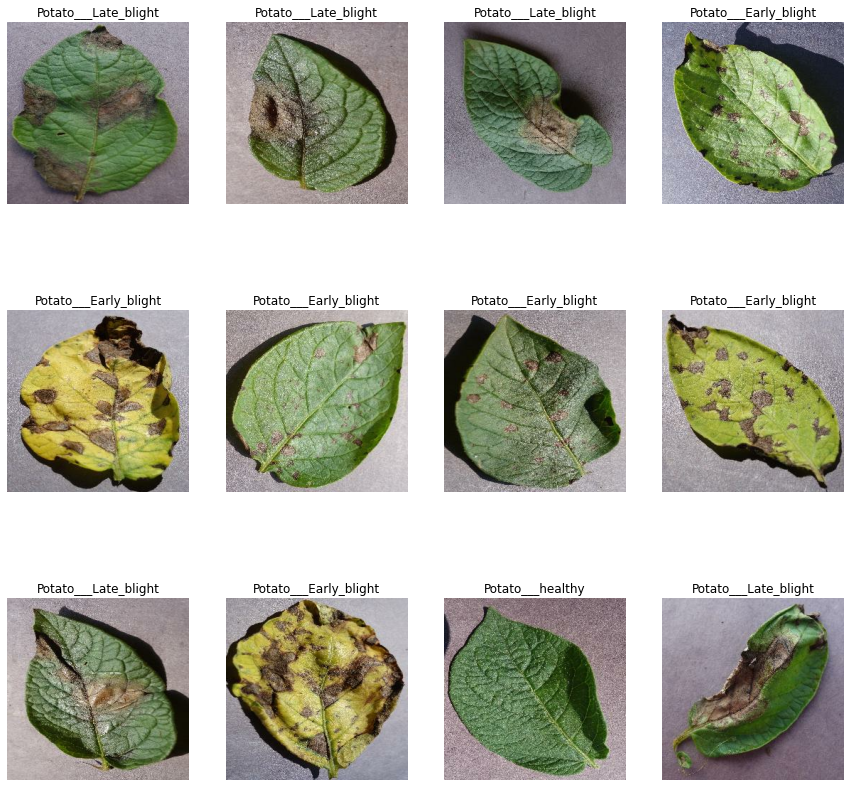

In [ ]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
len(dataset)

68

In [ ]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [ ]:
train_ds= dataset.take(516)
len(train_ds)

68

In [ ]:
test_ds = dataset.skip(516)
len(test_ds)

0

In [ ]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [ ]:
val_ds = test_ds.take(6)
len(val_ds)

0

In [ ]:
test_ds = test_ds.skip(6)
len(test_ds)

0

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

54

In [ ]:
len(val_ds)

6

In [ ]:
len(test_ds)

8

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
#Building the Model
#Creating a Layer for Resizing and Normalization
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
#Data Augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
#Applying Data Augmentation to Train Dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential ([

keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(256,256,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
    ])

model.build(input_shape=input_shape)


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 30, 30, 256)      1024      
 hNormalization)                                                 
                                                      

In [ ]:
#Compiling the Model
#use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit_generator(
    train_ds,
    validation_data=test_ds,
    steps_per_epoch=len(train_ds),
    epochs=EPOCHS, verbose=1
    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/10
54/54 [==============================] - 455s 6s/step - loss: 10.1435 - accuracy: 0.7274 - val_loss: 1447.2988 - val_accuracy: 0.5195
Epoch 2/10
54/54 [==============================] - 333s 6s/step - loss: 2.4850 - accuracy: 0.7616 - val_loss: 313.9107 - val_accuracy: 0.5195
Epoch 3/10
54/54 [==============================] - 334s 6s/step - loss: 1.1171 - accuracy: 0.7969 - val_loss: 153.2936 - val_accuracy: 0.6250
Epoch 4/10
54/54 [==============================] - 336s 6s/step - loss: 0.7904 - accuracy: 0.8258 - val_loss: 19.1594 - val_accuracy: 0.7539
Epoch 5/10
54/54 [==============================] - 336s 6s/step - loss: 0.5581 - accuracy: 0.8652 - val_loss: 11.5269 - val_accuracy: 0.7344
Epoch 6/10
54/54 [==============================] - 334s 6s/step - loss: 0.6782 - accuracy: 0.8536 - val_loss: 13.1082 - val_accuracy: 0.6680
Epoch 7/10
54/54 [==============================] - 334s 6s/step - loss: 0.4447 - accuracy: 0.8692 - val_loss: 2.6832 - val_accuracy: 0.6172
Ep

In [ ]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 12s 1s/step - loss: 2.8526 - accuracy: 0.6641


In [ ]:
scores

[2.8526382446289062, 0.6640625]

In [ ]:
history.params

{'epochs': 10, 'steps': 54, 'verbose': 1}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
#loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch
type(history.history['loss'])

list

In [ ]:
len(history.history['loss'])

10

In [ ]:
history.history['loss'][:5] # show loss for first 5 epochs

[10.143507957458496,
 2.4849698543548584,
 1.1170772314071655,
 0.7903591990470886,
 0.5581489205360413]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

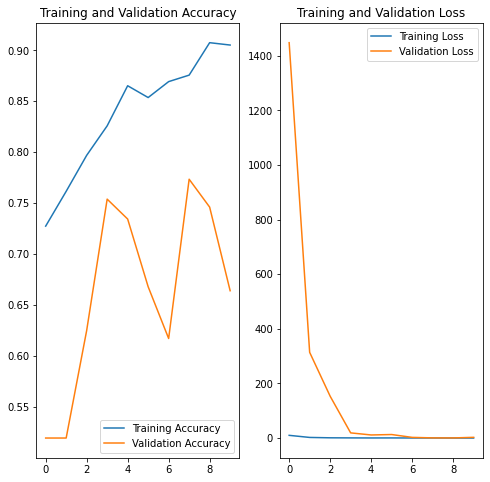

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
predicted label: Potato___Early_blight


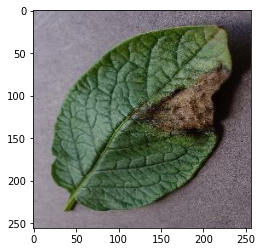

In [ ]:
#Run prediction on a sample image
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
#Write a function for inference
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

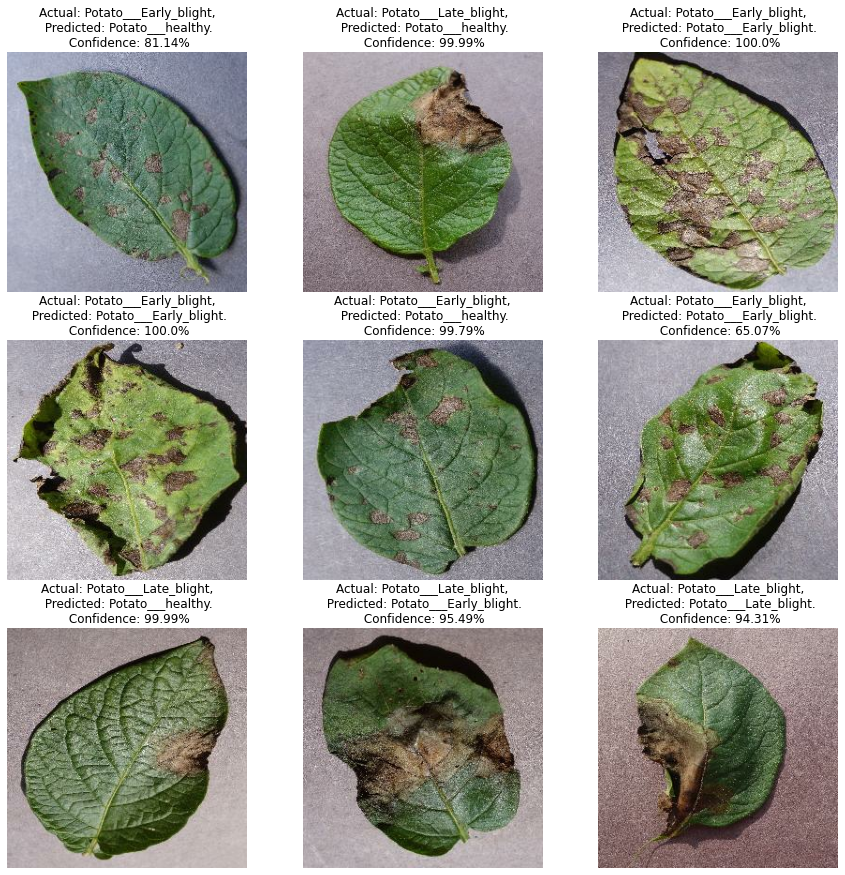

In [ ]:
#Now run inference on few sample images
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
#Saving the Model
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

FileNotFoundError: ignored